In [1]:
%matplotlib notebook

import librosa
import numpy as np
import pylab as pl
import os

from sklearn.cluster import MeanShift, estimate_bandwidth  
from sklearn.cluster import KMeans

from utils import ZCA, wav2audio_segment

from sklearn import manifold 

import pandas as pd


#This two classes are the same, should we use a parent class, or just one
class Descriptor():
    
    function = None
    data = None
    params = None
    data = None
    
    def __init__(self,data):
        self.name = data['name']
        self.params = data['params']
        self.function = data['function']
        
    def set_func(self,func):
        self.function=func
        
    def perform(self,input_data):
        self.data = self.function(self,input_data)
#         return self.descriptor

class Manifold():
    
    function = None
    data = None
    params = None
    data = None
    
    def __init__(self,data):
        self.name = data['name']
        self.params = data['params']
        self.function = data['function']
        
    def set_func(self,func):
        self.function=func
        
    def perform(self,input_data):
        self.data = self.function(self,input_data)

Choose a WAV mono file, and set the frame size (NFFT) and hop, and other parameters

In [2]:
path = "../wavs/"
fnames = os.listdir(path)
fnames = ["Xenakis_Metastasis.wav"]
fnames = ["Stockhausen_Kontakte.wav"]
fnames = ["Grisey_partiels.wav"]

sr = 44100

cqt_n_bins = 60 * 2     
n_mfcc = 20
NFFT = 2**12
HOP = NFFT/2

n_components = 2

Add descriptors

In [3]:
DESCRIPTORS = [
{'name':'stft',
  'params': {"n_fft":NFFT, "hop_length":HOP},
  'function': lambda self,y: np.abs( librosa.stft(y,**self.params).T ) },

{'name': 'mfcc',
 'params': {'n_mfcc':n_mfcc,'sr':sr,"n_fft":NFFT, "hop_length":HOP},
 'function': lambda self,y: librosa.feature.mfcc(y, **self.params).T },
    
{'name': 'scontrast',
 'params': {'sr':sr,"n_fft":NFFT, "hop_length":HOP} ,
 'function' : lambda self,y: librosa.feature.spectral_contrast(y, **self.params).T },

{'name': 'chroma',
 'params':{'n_fft':NFFT,'hop_length':HOP} ,
 'function': lambda self, y: librosa.feature.chroma_stft(y, **self.params).T }]

Add dimensionality reduction methods

In [4]:
n_neighbors = 10
        
MANIFOLDS = [
{'name':'LLE Mod',
  'params': {"n_neighbors":5, "eigen_solver":'auto',"method":"modified"},
  'function': lambda self,y: manifold.LocallyLinearEmbedding(**self.params).fit_transform(y) },

{'name': 'SpectralEmbedding',
 'params': {'n_components':5,'n_neighbors':n_neighbors},
 'function': lambda self,y: manifold.SpectralEmbedding(**self.params).fit_transform(y) },        
        
{'name': 'Isomap',
 'params': {'n_components':2,'n_neighbors':n_neighbors},
 'function': lambda self,y: manifold.Isomap(**self.params).fit_transform(y) }]


Compute descriptors

In [90]:
audio = {}
df = pd.DataFrame()

for fname in fnames:
    sr, signal  = wav2audio_segment(path+fname,60,80)

    ntotal = signal.size
    durtotal = ntotal/sr
    
    audio[fname] = {"D":{},"M":[]}
    
    for D in DESCRIPTORS:
        d = Descriptor(D)
        d.perform(signal)
        df = df.append( {"Audio":fname, "Descriptor":d.name,"D":d }, ignore_index=True )


/usr/local/lib/python3.4/dist-packages/numpy/core/numeric.py:482: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return array(a, dtype, copy=False, order=order)


Compute reduction

In [154]:
df2 = pd.DataFrame()
for i,r in df.iterrows(): 

    X = r.D.data

    for M in MANIFOLDS:
        m = Manifold(M)
        m.perform(X)
        df2 = df2.append( {"Audio":fname, "Descriptor":r.D.name,"D":r.D, "Manifold":m.name, "M":m }, ignore_index=True )    

Plot all results

In [ ]:

# for fname in fnames:
    
#     for n,m in audio[fname]["M"]:
        
#         Y = m.data

#         time_color = pl.cm.jet(np.linspace(0,1,Y.shape[0]))
#         pl.figure()
#         pl.subplot(2,1,1)
#         pl.scatter(Y[:, 0], Y[:, 1],c=time_color,alpha=0.4, edgecolors='none')
#         pl.title(n + ' ' + m.name)        

#         pl.subplot(2,1,2)
#         pl.plot(Y)                

#         pl.draw()      
        

Plot selected result

<IPython.core.display.Javascript object>


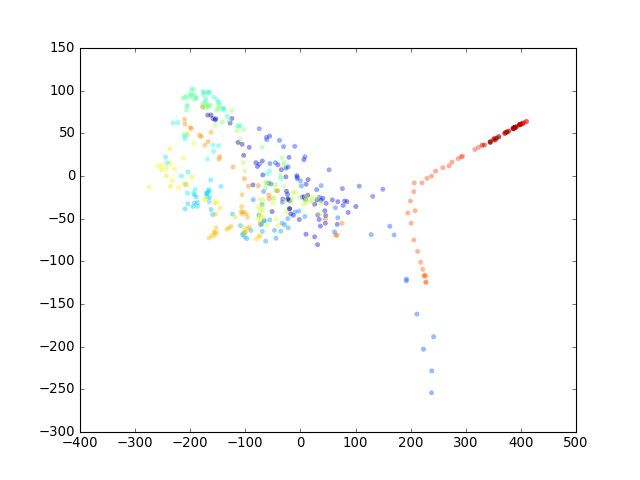

In [35]:
m = df2[(df2.Descriptor=='mfcc') & (df2.Manifold == 'Isomap')].M.values[0]
            
Y = m.data

time_color = pl.cm.jet(np.linspace(0,1,Y.shape[0]))
pl.figure()
pl.scatter(Y[:, 0], Y[:, 1],c=time_color,alpha=0.4, edgecolors='none')

Select region and play all sounds

In [ ]:
punto = np.array([-0,-0])
d = np.linalg.norm(Y-punto,axis=1)
ix = np.where(d<30)[0]

framesix = np.array([np.arange(i,i+NFFT) for i in range(0,signal.size,int(HOP))])

fragments = signal[framesix[ix]]
fragments = fragments.reshape(fragments.size)

import IPython
IPython.display.Audio(data=fragments,rate=sr)

In [ ]:
import pandas as pd
from pandas.tools.plotting import scatter_matrix
scatter_matrix(pd.DataFrame(Y), alpha=0.2, figsize=(12, 12))

Self Organized Maps where previously used for timbre analysis

In [119]:
import sompy

d = df2[(df2.Descriptor=='mfcc')].iloc[0].D

mapsize = [40,40]
som = sompy.SOMFactory.build(d.data, mapsize, mask=None, mapshape='planar', lattice='rect', normalization='var', initialization='pca', neighborhood='gaussian', training='batch', name='sompy')  # this will use the default parameters, but i can change the initialization and neighborhood methods
som.train(n_job=1, verbose='info')  # verbose='debug' will print more, and verbose=None wont print anything



 Training...
 pca_linear_initialization took: 0.010000 seconds
 Rough training...
 radius_ini: 5.000000 , radius_final: 1.250000, trainlen: 112

 epoch: 1 ---> elapsed time:  0.138000, quantization error: 3.345422

 epoch: 2 ---> elapsed time:  0.132000, quantization error: 2.931773

 epoch: 3 ---> elapsed time:  0.129000, quantization error: 2.594442

 epoch: 4 ---> elapsed time:  0.132000, quantization error: 2.483266

 epoch: 5 ---> elapsed time:  0.130000, quantization error: 2.434996

 epoch: 6 ---> elapsed time:  0.132000, quantization error: 2.403986

 epoch: 7 ---> elapsed time:  0.129000, quantization error: 2.380797

 epoch: 8 ---> elapsed time:  0.132000, quantization error: 2.365184

 epoch: 9 ---> elapsed time:  0.128000, quantization error: 2.348904

 epoch: 10 ---> elapsed time:  0.132000, quantization error: 2.334882

 epoch: 11 ---> elapsed time:  0.130000, quantization error: 2.322091

 epoch: 12 ---> elapsed time:  0.131000, quantization error: 2.311414

 epoch: 13 -

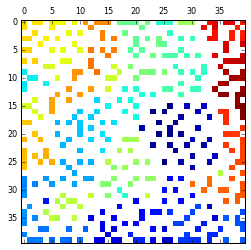

In [145]:
proy = som.project_data(d.data)
MS = 40

I = np.empty(mapsize)
I[:] = np.NAN

K = {i:[] for i in range(np.prod(mapsize))}
for i,p in enumerate(proy):
    K[p].append(i)
    I[p%MS,p//MS] = i
    
pl.matshow(I)

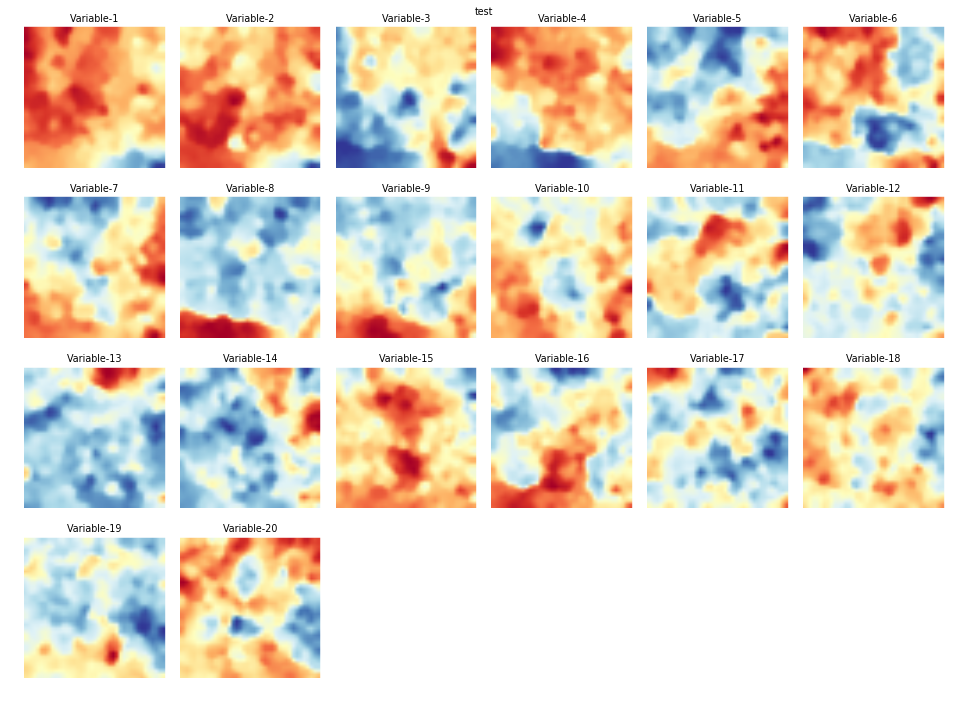

In [152]:
%matplotlib inline
v = sompy.mapview.View2DPacked(50, 50, 'test',text_size=8)  
# could be done in a one-liner: sompy.mapview.View2DPacked(300, 300, 'test').show(som)
v.show(som, what='codebook', which_dim='all', cmap=None, col_sz=6) #which_dim='all' default
# v.save('2d_packed_test')



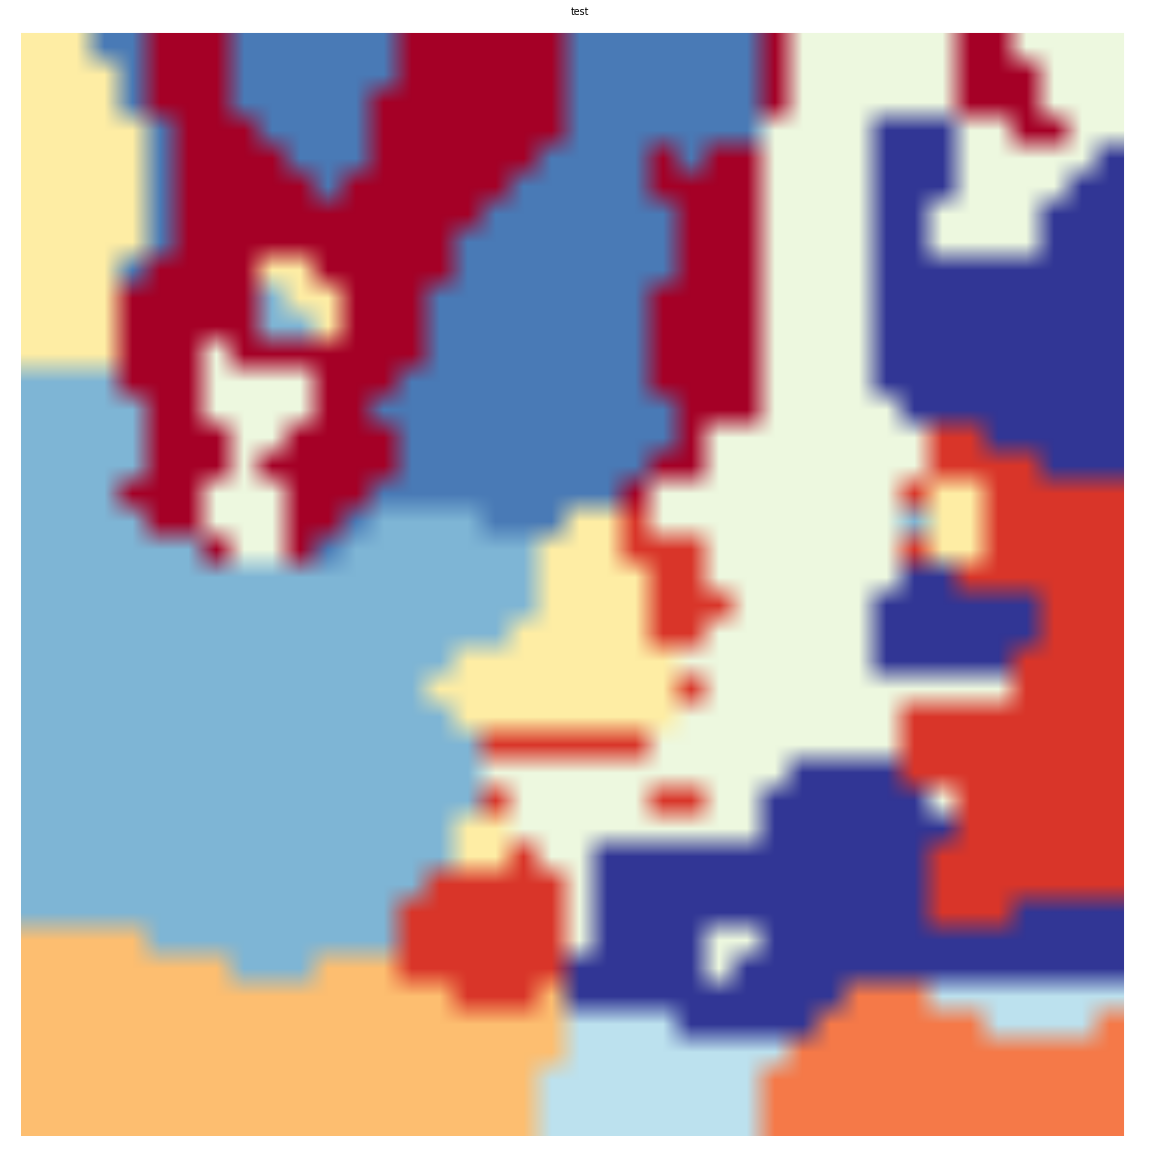

In [123]:
cl = som.cluster(n_clusters=10)
som.cluster_labels.shape
pl.figure()
v.show(som, what='cluster')

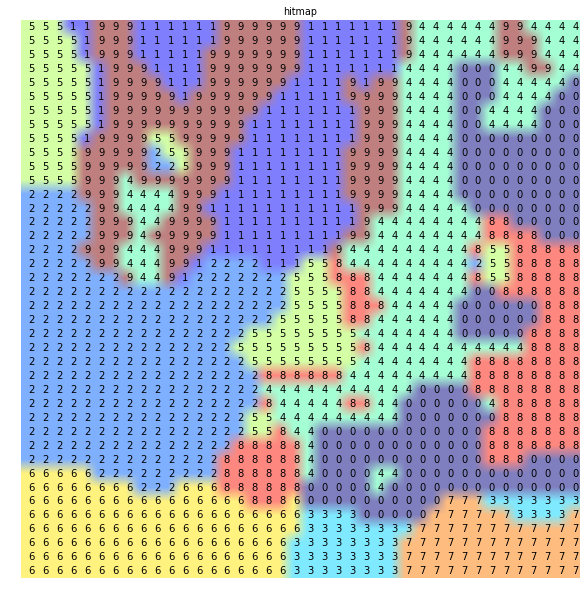

array([[   0,    0,    0],
       [   0,    1,    1],
       [   0,    2,    2],
       ..., 
       [  39,   37, 1597],
       [  39,   38, 1598],
       [  39,   39, 1599]])

In [124]:

h = sompy.hitmap.HitMapView(10, 10, 'hitmap', text_size=8, show_text=True)
h.show(som)


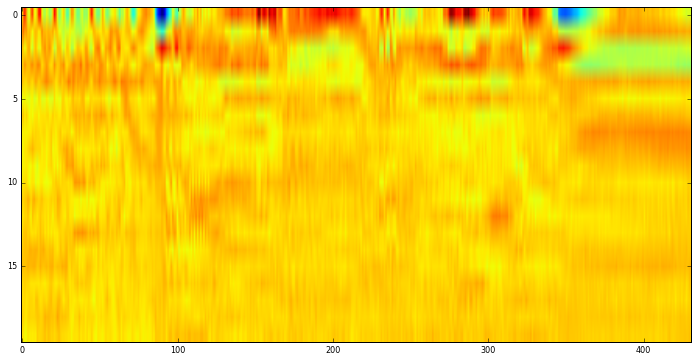

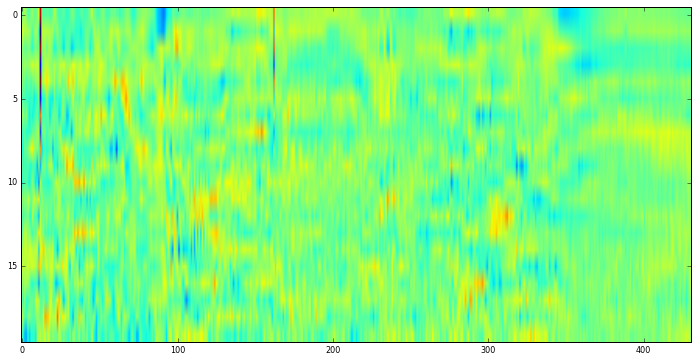

In [97]:
d = df2[(df2.Descriptor=='mfcc')].iloc[0].D

pl.figure(figsize=(12,6))
pl.imshow(d.data.T,aspect='auto')
zca=ZCA()
x = zca.fit(d.data).transform(d.data)
pl.figure(figsize=(12,6))
pl.imshow(x.T,aspect='auto')
